In [1]:
# Cell 1: import e funzioni helper
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.linalg import eigh
import math

plt.rcParams.update({"figure.figsize": (7,4), "font.size": 12})

# Funzioni del problema (stessa definizione usata in C++)
def V(x):
    return x**4 - 2.5 * x**2

def g(x, a, sigma):
    return np.exp(- (x - a)**2 / (2.0 * sigma**2))

def psi(x, sigma, mu):
    return g(x, +mu, sigma) + g(x, -mu, sigma)

def psi2_analytic(x, sigma, mu):
    p = psi(x, sigma, mu)
    return p*p

# normalizza una funzione (integrazione semplice)
def normalize_1d(x, y):
    # x grid, y values (>=0), returns normalized y such that integral y dx = 1
    integral = np.trapz(y, x)
    if integral <= 0:
        return y
    return y / integral


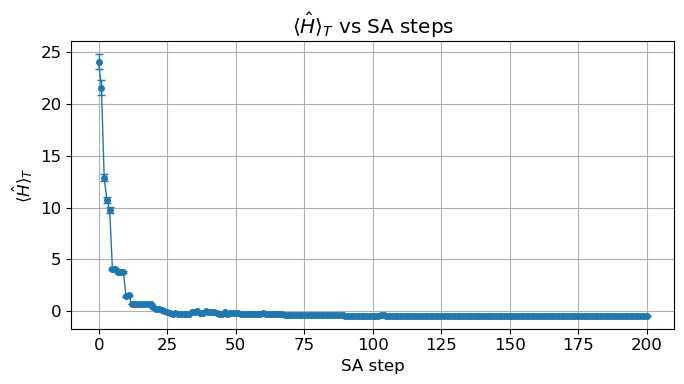

In [2]:
# Cell 2: plot <H> ± errore vs SA step
data = np.loadtxt("sa_history.dat", comments="#")
# columns: step, T_sa, H_avg, H_err, mu, sigma, accept_flag, acc_rate_MC
step = data[:,0].astype(int)
Tsa  = data[:,1]
Havg = data[:,2]
Herr = data[:,3]
mu_hist = data[:,4]
sigma_hist = data[:,5]
accept_flag = data[:,6]

plt.figure()
plt.errorbar(step, Havg, yerr=Herr, fmt='o-', markersize=4, lw=1, capsize=3)
plt.xlabel("SA step")
plt.ylabel(r"$\langle \hat H \rangle_T$")
plt.title(r"$\langle \hat H \rangle_T$ vs SA steps")
plt.grid(True)
plt.tight_layout()
plt.show()


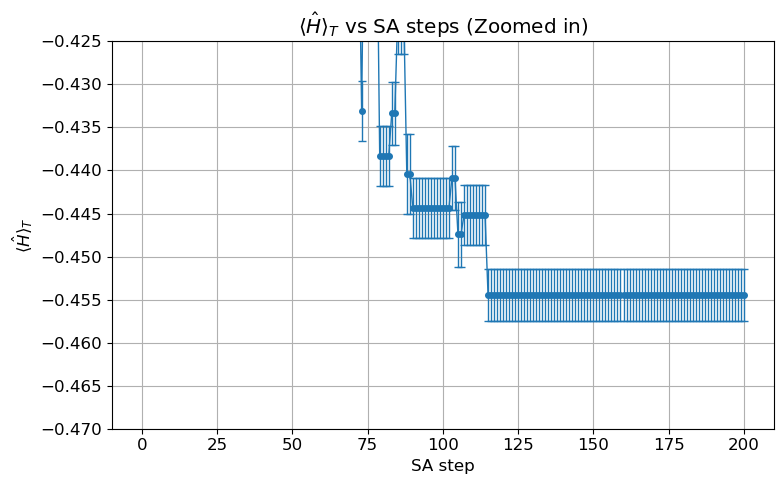

In [9]:
plt.figure()
plt.errorbar(step, Havg, yerr=Herr, fmt='o-', markersize=4, lw=1, capsize=3)
plt.xlabel("SA step")
plt.ylabel(r"$\langle \hat H \rangle_T$")
plt.title(r"$\langle \hat H \rangle_T$ vs SA steps (Zoomed in)")
plt.grid(True)
plt.ylim(-0.47, -0.425)  #range dell'asse y
plt.tight_layout()
plt.show()

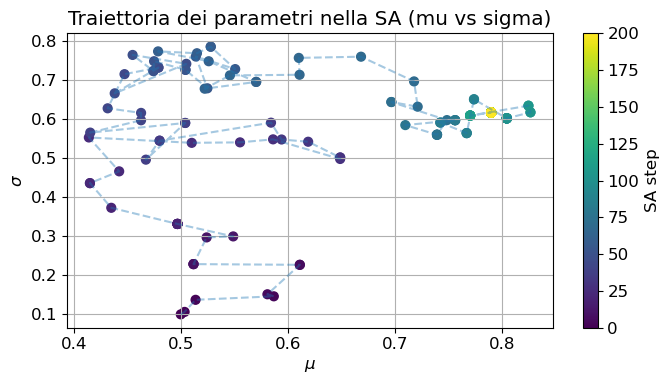

In [4]:
# Cell 3: trajectory mu vs sigma (colored by step)
plt.figure()
sc = plt.scatter(mu_hist, sigma_hist, c=step, cmap='viridis', s=40)
plt.plot(mu_hist, sigma_hist, linestyle='--', alpha=0.4)  # collega i punti per visuale
plt.colorbar(sc, label="SA step")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
plt.title("Traiettoria dei parametri nella SA (mu vs sigma)")
plt.grid(True)
plt.tight_layout()
plt.show()


[INFO] Letti 27 punti da energy_blocks_opt.dat.


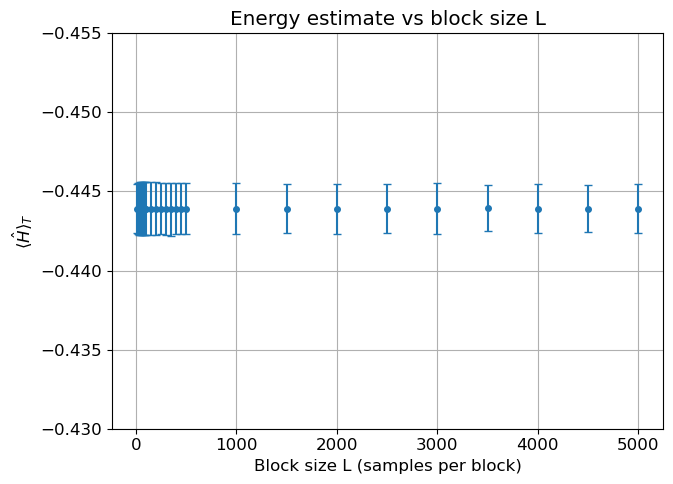

[INFO] mu_opt=0.789789, sigma_opt=0.617387


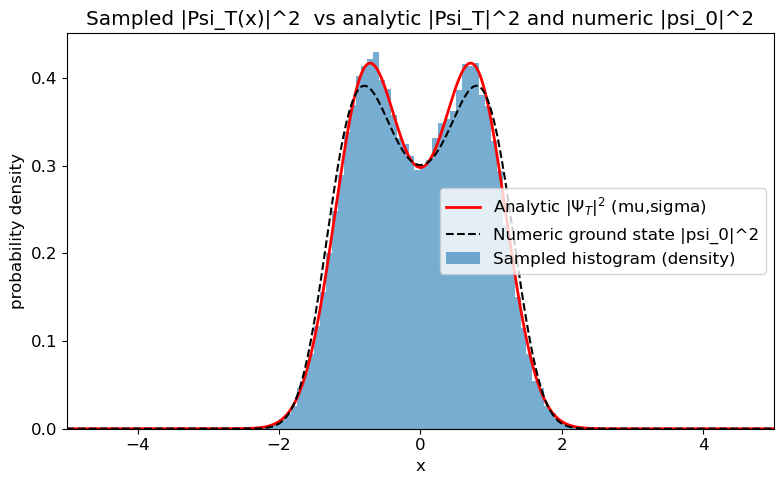

[DONE] histogram: N_samples=180000, bins=120.
[INFO] numeric ground-state min energy (approx) = -0.460472


In [21]:
# Notebook cell: (1) H vs block size L; (2) histogram of sampled |psi_T|^2 vs analytic and numerical ground state
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy.linalg import eigh

plt.rcParams.update({'figure.max_open_warning': 0})

# ---------- helper functions ----------
def read_last_params(sa_file="sa_history.dat"):
    """Legge l'ultima riga non-commento di sa_history.dat e restituisce (mu,sigma)."""
    if not os.path.exists(sa_file):
        print(f"[WARN] {sa_file} non trovato.")
        return None, None
    mu = sigma = None
    with open(sa_file,'r') as f:
        for line in f:
            line = line.strip()
            if line=="" or line.startswith('#'): 
                continue
            parts = line.split()
            try:
                step = int(parts[0])
                # format used in C++: step T_sa H_avg H_err mu sigma accept_flag acc_rate_MC
                mu = float(parts[4])
                sigma = float(parts[5])
            except:
                continue
    return mu, sigma

def local_energy_py(x, mu, sigma):
    """Implementazione stabile dell'energia locale come nel C++ (usa pesi scalati)."""
    # log-arg for the two gaussians
    l1 = - ((x - mu)**2) / (2.0*sigma*sigma)
    l2 = - ((x + mu)**2) / (2.0*sigma*sigma)
    m = max(l1, l2)
    w1 = np.exp(l1 - m)
    w2 = np.exp(l2 - m)
    denom = w1 + w2
    # factors g''/g
    factor1 = ((x-mu)**2)/(sigma**4) - 1.0/(sigma*sigma)
    factor2 = ((x+mu)**2)/(sigma**4) - 1.0/(sigma*sigma)
    psi_dd_over_psi = (factor1 * w1 + factor2 * w2) / denom
    kinetic = -0.5 * psi_dd_over_psi
    V = x**4 - 2.5 * x**2
    return kinetic + V

def block_error(blocks):
    n = len(blocks)
    if n <= 1: return 0.0
    mean = np.mean(blocks)
    var = np.mean(np.square(blocks)) - mean*mean
    if var < 0: var = 0.0
    return np.sqrt(var / float(n))

# ---------- 1) H vs block size L ----------
# Preferisco leggere energy_blocks_opt.dat se esiste (prodotto dal C++).
eb_file = "energy_blocks_opt.dat"
L_vals = []
H_means = []
H_errs  = []

if os.path.exists(eb_file):
    data = np.loadtxt(eb_file, comments="#")
    # expected columns: L, Nblocks, H_mean, H_error
    if data.ndim == 1 and data.size>=4:
        data = data.reshape((1,data.size))
    L_vals = data[:,0].astype(int)
    H_means = data[:,2]
    H_errs  = data[:,3]
    print(f"[INFO] Letti {len(L_vals)} punti da {eb_file}.")
else:
    # fallback: ricostruisco a partire da samples_opt.dat usando local_energy_py
    samp_file = "samples_opt.dat"
    mu_opt, sigma_opt = read_last_params()
    if mu_opt is None or sigma_opt is None:
        print("[ERROR] Non trovo parametri ottimali in sa_history.dat e mancava energy_blocks_opt.dat.")
        print("         Metti sa_history.dat o energy_blocks_opt.dat nella cartella di lavoro.")
    elif not os.path.exists(samp_file):
        print(f"[ERROR] Né {eb_file} né {samp_file} esistono; non posso ricostruire L vs H.")
    else:
        samples = np.loadtxt(samp_file)
        M_eff = len(samples)
        print(f"[INFO] Ricostruisco H(L) da {samp_file}, N_samples={M_eff}, usando mu={mu_opt}, sigma={sigma_opt}")
        # definisco la lista L come nel C++: vario L e calcolo Nblocks = M_eff // L
        L_list = []
        L=10
        while L <= 5000 and L <= M_eff:
            L_list.append(L)
            if L < 100: L += 10
            elif L < 500: L += 50
            else: L += 500
        L_vals=[]
        H_means=[]
        H_errs=[]
        for L in L_list:
            if L > M_eff: break
            Nblocks = M_eff // L
            if Nblocks < 2: continue
            block_means=[]
            idx = 0
            for b in range(Nblocks):
                block = samples[idx:idx+L]
                idx += L
                # evaluate local energies on the block
                eblock = [local_energy_py(x, mu_opt, sigma_opt) for x in block]
                block_means.append(np.mean(eblock))
            L_vals.append(L)
            H_means.append(np.mean(block_means))
            H_errs.append(block_error(block_means))
        print(f"[INFO] Ricostruito {len(L_vals)} punti H(L).")

# Plot H vs L
if len(L_vals)>0:
    plt.figure(figsize=(7,5))
    plt.errorbar(L_vals, H_means, yerr=H_errs, fmt='o', ms=4, capsize=3)
    plt.xlabel("Block size L (samples per block)")
    plt.ylabel(r'$\langle \hat{H} \rangle_T$')
    plt.title("Energy estimate vs block size L")
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(-0.43, -0.455)
    plt.show()
else:
    print("[WARN] Nessun dato H(L) disponibile per il plot.")

# ---------- 2) Histogram |Psi_T|^2 vs analytic and numerical ground state ----------
# read mu,sigma from sa_history if possible; else try a best-effort: see if samples produced by some mu
mu_opt, sigma_opt = read_last_params()
if mu_opt is None or sigma_opt is None:
    print("[WARN] Parametri ottimali (mu,sigma) non trovati: proverò a leggere samples_opt.dat comunque.")
else:
    print(f"[INFO] mu_opt={mu_opt:.6f}, sigma_opt={sigma_opt:.6f}")

samp_file = "samples_opt.dat"
if not os.path.exists(samp_file):
    print(f"[ERROR] {samp_file} non trovato: non posso fare histogram vs |psi|^2.")
else:
    samples = np.loadtxt(samp_file)
    # histogram of samples (density)
    nbin = 120
    xmin, xmax = -5.0, 5.0
    bins = np.linspace(xmin, xmax, nbin+1)
    hist_counts, edges = np.histogram(samples, bins=bins, density=True)
    mids = 0.5*(edges[:-1]+edges[1:])

    # analytic psi_T^2 (unnormalized), normalize numerically
    if mu_opt is None or sigma_opt is None:
        mu_use = 0.78 # fallback (user should supply real)
        sigma_use = 0.66
        print(f"[WARN] uso fallback mu={mu_use}, sigma={sigma_use} per la psi analitica.")
    else:
        mu_use = mu_opt
        sigma_use = sigma_opt

    def psi_T(x, mu, sigma):
        return np.exp(-((x-mu)**2)/(2*sigma*sigma)) + np.exp(-((x+mu)**2)/(2*sigma*sigma))
    xs_fine = np.linspace(xmin, xmax, 4001)
    psi_vals = psi_T(xs_fine, mu_use, sigma_use)
    psi2_analytic = psi_vals**2
    # normalize by numeric integration
    norm = np.trapz(psi2_analytic, xs_fine)
    psi2_analytic /= norm

    # numerical solution of Schrodinger eq (ground state) via FD
    Nx = 800
    xgrid = np.linspace(xmin, xmax, Nx)
    dx = xgrid[1]-xgrid[0]
    Vgrid = xgrid**4 - 2.5 * xgrid**2
    # build tridiagonal Hamiltonian H = -1/2 D2 + V
    diag = np.ones(Nx) * (1.0 / (dx*dx)) + Vgrid  # kinetic diag = 1/dx^2
    off  = np.ones(Nx-1) * (-1.0/(2.0*dx*dx))
    Hmat = np.diag(diag) + np.diag(off,1) + np.diag(off,-1)
    # compute lowest eigenvector (use eigh)
    try:
        vals, vecs = eigh(Hmat)
        psi0 = vecs[:,0]
        # normalize
        psi0_sq = psi0**2
        psi0_sq = psi0_sq / np.trapz(psi0_sq, xgrid)
        psi0_interp = np.interp(mids, xgrid, psi0_sq)
        numeric_ok = True
    except Exception as e:
        print("[WARN] Problema nel risolvere H numerico:", e)
        numeric_ok = False

    # Plot histogram with analytic and numeric curves
    plt.figure(figsize=(8,5))
    plt.bar(mids, hist_counts, width=(edges[1]-edges[0]), alpha=0.6, label="Sampled histogram (density)")
    plt.plot(xs_fine, psi2_analytic, 'r-', lw=2, label=r'Analytic $|\Psi_T|^2$ (mu,sigma)')
    if numeric_ok:
        plt.plot(xgrid, psi0_sq, 'k--', lw=1.5, label='Numeric ground state |psi_0|^2')
    plt.xlim(xmin, xmax)
    plt.xlabel("x")
    plt.ylabel("probability density")
    plt.title("Sampled |Psi_T(x)|^2  vs analytic |Psi_T|^2 and numeric |psi_0|^2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # also save a small diagnostic summary
    print(f"[DONE] histogram: N_samples={len(samples)}, bins={nbin}.")
    if numeric_ok:
        print(f"[INFO] numeric ground-state min energy (approx) = {vals[0]:.6f}")


La cella legge sa_history.dat per recuperare mu_opt e sigma_opt

- La soluzione numerica della Schrödinger è fatto con differenze finite su Nx=800 punti in [−5,5]
- 
## 1. Discretizzazione dello spazio
Si prende un intervallo finito, ad esempio 
[−5,5], e lo si divide in Nx punti (nel codice Nx = 800).
La distanza fra i punti è
$
dxmax = \frac{xmax⁡−xmin}{⁡Nx−1}.
$

## 2. Approssimazione della derivata seconda
Con il metodo delle differenze finite, la derivata seconda di una funzione $w(x)$ si approssima come:
$$
\psi''(x_i) \approx \frac{\psi(x_{i+1}) - 2\psi(x_i) + \psi(x_{i-1})}{h^2}
$$
dove:
- $x_i$ è il punto in cui si calcola la derivata
- $h = x_{i+1} - x_i$ (passo costante)
- $w(x_{i+1})$, $w(x_i)$, $w(x_{i-1})$ sono i valori della funzione nei punti vicini